# Feature Association Metrics: Pearson, Spearman, Distance Correlation, and Mutual Information for Feature Selection  

## 1. Why Select Non-Redundant Features?  

Feature selection is a critical step in machine learning to improve model performance, reduce overfitting, and enhance interpretability. By removing redundant features, we ensure that only the most representative features are retained, which can improve computational efficiency and help models generalize better to unseen data.  

Redundant features carry overlapping information, which can lead to inefficiencies in learning and may divert focus away from the most informative features. By reducing redundancy, we can highlight features that provide unique contributions to the model, ensuring that the learning process emphasizes the most relevant patterns and relationships in the data.  

By combining feature selection with techniques that measure feature associations or dependencies, we can create models that are simpler, more efficient, and better aligned with the underlying structure of the data.  


## 2. Introduction to Feature Association Metrics  

- **Pearson Correlation**  
  Pearson correlation measures the linear relationship between two variables, producing a value between -1 and 1. A value close to 1 indicates a strong positive linear association, while a value close to -1 indicates a strong negative linear association.  

- **Spearman Correlation**  
  Spearman correlation assesses the monotonic relationship between two variables by ranking their values. It is more robust to outliers and captures non-linear but monotonic associations, unlike Pearson correlation.  

- **Distance Correlation**  
  Distance correlation quantifies both linear and non-linear dependencies by computing the association between pairwise distances of data points. It is capable of detecting relationships that traditional correlation metrics might miss.  

- **Mutual Information**  
  Mutual information measures the dependency between two variables by quantifying the amount of shared information. It is a non-parametric method and is particularly effective at capturing complex, non-linear relationships.  

Pearson and Spearman correlations are parametric methods focused on linear and monotonic relationships, respectively. Distance correlation and mutual information are non-parametric, making them more versatile for detecting non-linear associations without assuming specific distributions or functional forms. While distance correlation captures dependencies through pairwise distances, mutual information quantifies the amount of shared information between variables.  

## 3. Using Correlation Metrics and Clustering for Feature Selection  

Correlation metrics help identify how features are associated with each other, providing insight into redundancies. However, simply analyzing pairwise correlations may not be sufficient for selecting a diverse set of features. **Agglomerative clustering** is a hierarchical clustering method that groups features based on their similarity.  

Agglomerative clustering starts by treating each feature as an individual cluster. It then iteratively merges the two most similar clusters based on a chosen distance metric until all features are part of a single cluster or a predefined number of clusters is reached. In the context of feature selection, similarity between features is typically measured using a distance metric derived from the correlation matrix (e.g., 1 - |correlation|).  

This approach groups similar features, enabling the systematic selection of one representative feature from each group. By removing features that are too closely related, we ensure that the retained features are diverse and minimize redundancy while preserving the most useful information for downstream tasks.  

While reducing redundancy does not directly reveal causal relationships, it helps focus on features that provide unique and potentially impactful information. This can improve model interpretability and ensure that meaningful relationships in the data are emphasized.    

## 4. The Experiment: Exploring Feature Selection with Clustering

In this notebook, we will:  
1. Generate synthetic data to demonstrate feature associations.  
2. Use Pearson correlation, Spearman correlation, Distance Correlation, and Mutual Information to assess feature dependencies.  
3. Apply agglomerative clustering to group features and select non-redundant ones based on their dissimilarity.  

This demonstration will show how to efficiently select representative features for machine learning models by prioritizing those that provide unique information and reduce redundancy.

### 4.1 Function Definition and Imports

In [ ]:
# Install the necessary libraries
!pip install -q matplotlib pandas scipy scikit-learn numpy dcor

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import mutual_info_regression
import dcor

def plot_dendrogram(correlation_matrix, ax, title='Dendrogram', min_distance=0.0, method='ward'):
    """
    Plot a dendrogram based on a correlation matrix using hierarchical clustering.
    
    Parameters:
        correlation_matrix (pd.DataFrame): Correlation matrix with numerical values.
        ax (matplotlib.axes.Axes): Axis to plot the dendrogram on.
        title (str): Title for the dendrogram plot. Default is 'Dendrogram'.
        min_distance (float): Minimum distance threshold to adjust the linkage distances.
        method (str): Linkage method used for clustering. Default is 'ward'.
    
    Returns:
        None
    """
    # Convert correlation to distance (1 - absolute correlation)
    distance_matrix = 1 - correlation_matrix.abs()
    
    # Set diagonal elements to 0 (distance to self is 0)
    np.fill_diagonal(distance_matrix.values, 0)

    # Convert the distance matrix to condensed form
    condensed_distances = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_distances, method=method)

    # Apply minimum distance threshold
    linkage_matrix[:, 2] = np.maximum(linkage_matrix[:, 2], min_distance)

    # Plot the dendrogram on the provided axis
    dendro = dendrogram(linkage_matrix,
                        labels=distance_matrix.columns,
                        leaf_font_size=6,
                        ax=ax)

    # Annotate the dendrogram with distance values
    for i, d in zip(dendro['icoord'], dendro['dcoord']):
        ax.text((i[1] + i[2]) / 2, d[1], f'{d[1]:.2f}', va='center', ha='right', fontsize=8)

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel("Features")
    ax.set_ylabel("Distance")

def distance_correlation_matrix(data):
    """
    Calculate the distance correlation between all pairs of columns in a pandas DataFrame.

    Distance correlation is a measure of statistical dependence between two features.
    It can detect both linear and non-linear relationships.

    Parameters:
        data (pd.DataFrame): Input data with numerical columns. Each column represents a feature.

    Returns:
        pd.DataFrame: A symmetric matrix of distance correlation scores for each pair of columns.
                      The diagonal elements represent the distance correlation of a column with itself.
    """
    # Ensure input consists of numeric columns only
    data = data.select_dtypes(include=[np.number])

    n = data.shape[1]  # Number of features (columns)
    columns = data.columns  # Column names
    dc_matrix = np.zeros((n, n))  # Initialize the distance correlation matrix

    # Compute distance correlation for each pair of features (i, j)
    for i in range(n):
        for j in range(i, n):  # Compute only the upper triangular part of the matrix
            dc = dcor.distance_correlation(data.iloc[:, i], data.iloc[:, j])

            # Fill the symmetric matrix with the computed distance correlation
            dc_matrix[i, j] = dc
            dc_matrix[j, i] = dc  # Matrix is symmetric

    # Convert the matrix to a pandas DataFrame for readability
    dc_df = pd.DataFrame(dc_matrix, index=columns, columns=columns)
    return dc_df

def mutual_information_matrix(data):
    """
    Calculate the normalized mutual information between all pairs of columns in a pandas DataFrame.

    Mutual information measures the dependency between two features and can detect both linear
    and non-linear monotonic relationships. The values are normalized to a range between 0 and 1.

    Parameters:
        data (pd.DataFrame): Input data with numerical columns. Each column represents a feature.

    Returns:
        pd.DataFrame: A symmetric matrix of normalized mutual information scores (range: 0 to 1).
                      The diagonal elements represent the mutual information of a column with itself.
    """
    # Ensure input consists of numeric columns only
    data = data.select_dtypes(include=[np.number])

    n = data.shape[1]  # Number of features (columns)
    columns = data.columns  # Column names
    mi_matrix = np.zeros((n, n))  # Initialize the mutual information matrix

    # Compute mutual information for each pair of features (i, j)
    for i in range(n):
        for j in range(i, n):  # Compute only the upper triangular part of the matrix
            x = data.iloc[:, i].values.reshape(-1, 1)
            y = data.iloc[:, j].values

            if i == j:
                # Self-mutual information (highest value for a single feature)
                mi = mutual_info_regression(x, x.ravel())[0]
            else:
                # Compute mutual information between different features
                mi = mutual_info_regression(x, y)[0]

            # Fill the symmetric matrix with the computed mutual information
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi  # Matrix is symmetric

    # Convert the matrix to a pandas DataFrame for readability
    mi_df = pd.DataFrame(mi_matrix, index=columns, columns=columns)

    # Normalize the matrix so the diagonal values are 1 (self-correlation)
    mi_df /= mi_df.max().max()

    return mi_df

## 4.2 Synthetic Data

In this experiment, we generate synthetic data to demonstrate the feature selection method. Each signal is combined with noise to model the aleatoric uncertainty typically observed in real-world datasets. The noise follows a normal distribution with a mean of 0 and a standard deviation of 0.1.

The signals are defined as follows:

1. $Y = X + \mathcal{N}(0, 0.1)$
2. $Y = 2X + \mathcal{N}(0, 0.1)$
3. $Y = X^2 + \mathcal{N}(0, 0.1)$
4. $Y = \sin(X) + \mathcal{N}(0, 0.1)$
5. $Y = \cos(X) + \mathcal{N}(0, 0.1)$
6. $Y = \mathcal{N}(0, 1)$

Where:
- $X$ represents the underlying signal.
- $\mathcal{N}(0, \sigma)$ denotes Gaussian noise with mean 0 and standard deviation $\sigma$.

Signal 6 represents pure noise, which is used to demonstrate how noise—when not associated with any underlying pattern—appears distinct from the other signals. This is crucial for evaluating how well the method differentiates between actual patterns in the data and random noise. Pure noise, with no discernible structure, should stand out in the analysis.

This setup allows for testing how the method handles various types of signals and noise, and how well it can differentiate between expected patterns and random fluctuations.

In [5]:
# Generate random noise and the signal (X)
noise = np.random.normal(0, 1, 10000)  # Pure noise (N(0,1))
x = np.linspace(-10, 10, 10000)  # The underlying signal (X)

# Create a dictionary to hold all the signals with noise
signals = {}

# Define the signals
signals['x+N(0,0.1)'] = x + np.random.normal(0, 0.1, 10000)  # X + Gaussian noise
signals['2x+N(0,0.1)'] = 2*x + np.random.normal(0, 0.1, 10000)  # 2X + Gaussian noise
signals['x^2+N(0,0.1)'] = x**2 + np.random.normal(0, 0.1, 10000)  # X^2 + Gaussian noise
signals['sin(x)+N(0,0.1)'] = np.sin(x) + np.random.normal(0, 0.1, 10000)  # sin(X) + Gaussian noise
signals['cos(x)+N(0,0.1)'] = np.cos(x) + np.random.normal(0, 0.1, 10000)  # cos(X) + Gaussian noise
signals['N(0,1)'] = noise  # Pure noise

# Convert the dictionary into a pandas DataFrame
signals = pd.DataFrame(signals)

## 4.3 Analyzing the Relationships Between Signals

In this section, we will calculate the correlations and mutual information between the generated signals. We'll use both the built-in pandas functions for standard correlation metrics (such as Pearson and Spearman) and the custom-defined functions for computing Mutual Information and Distance Correlation. This analysis will provide insights into the relationships between the signals, helping us understand how the features interact with each other.

We will begin by calculating the following metrics:
- **Pearson Correlation**: Measures the linear relationship between pairs of features.
- **Spearman Correlation**: Assesses the monotonic relationship, which is less sensitive to outliers.
- **Mutual Information**: Quantifies the amount of shared information between pairs of features, capturing both linear and non-linear dependencies.
- **Distance Correlation**: Measures the dependence between pairs of features, accounting for both linear and non-linear relationships.

Let’s proceed with the calculations.

In [6]:
# Now calculate the correlation matrices
correlations = {}
correlations['Pearson'] = signals.corr(method = 'pearson')
correlations['Spearman'] = signals.corr(method = 'spearman')
correlations['Mutual Information'] = mutual_information_matrix(signals)
correlations['Distance Correlation'] = distance_correlation_matrix(signals)

## 4.4 Visualizing Feature Relationships with Dendrograms

After calculating the correlation and mutual information metrics, we will visualize the similarity between features using dendrograms. Dendrograms are hierarchical tree diagrams that display the arrangement of features based on their pairwise similarity.

We will use the previously defined function to plot the dendrograms, which will help us observe how the features cluster together. By examining these visualizations, we can gain insights into which features are closely related and which are more independent, aiding in the selection of non-redundant features for further analysis.

Let’s proceed with plotting the dendrograms.

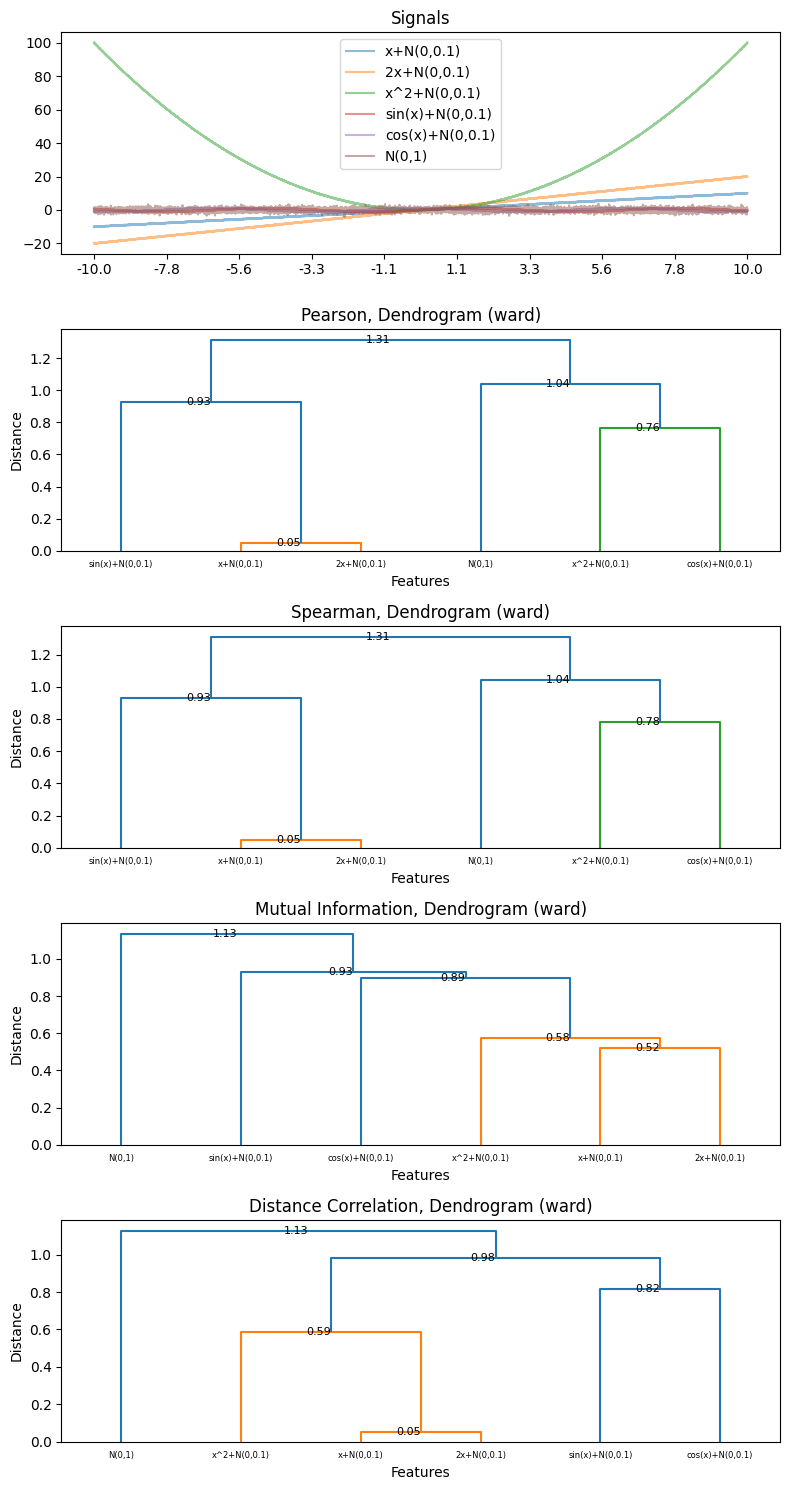

In [7]:
fig, ax = plt.subplots(figsize=(8, 15), nrows=5, ncols=1)  
ax = ax.ravel()

# Plot the signals in the first subplot
for key in signals:
    ax[0].set_title('Signals')
    ax[0].plot(signals[key], label=key, alpha=0.5)  
    
    # Set x-axis tick positions and labels
    ax[0].set_xticks(np.linspace(0, len(x) - 1, 10))
    ax[0].set_xticklabels(np.round(np.linspace(x.min(), x.max(), 10), 1))  # Set tick labels

# Plot the dendrograms for each correlation matrix in the remaining subplots
for idx, key in enumerate(correlations):
    plot_dendrogram(correlations[key], ax[idx+1], title=f'{key}, Dendrogram (ward)', min_distance=0.05)

ax[0].legend()
fig.tight_layout()

As observed from the dendrograms, Pearson and Spearman correlations are effective at capturing only linear or monotonic relationships between signals. Specifically, they can identify the relationship between signals $X$ and $2X$, but fail to correctly identify other associations, often grouping them randomly. In contrast, both Mutual Information and Distance Correlation are better equipped to capture not only linear relationships but also non-linear ones. These methods accurately identify the linear relationship between $X$ and $2X$, while also recognizing the non-linear similarity between $X$ and $X^2$. Additionally, they detect the similarity between $\sin(X)$ and $\cos(X)$, with Distance Correlation suggesting a stronger similarity than Mutual Information, though both methods classify them as distant yet still part of the same group. Notably, all methods tend to isolate the noise signal $\mathcal{N}(0, 1)$ as a separate cluster. Mutual Information and Distance Correlation, however, distinguish it more clearly from the rest of the signals, marking it as particularly distinct.

## 4.4 Final Feature Selection

The primary objective of this experiment was to identify and eliminate redundant features, ensuring that the final feature set consists of the most informative and diverse features. Based on the results from the correlation metrics and dendrograms, we can filter out highly correlated features that provide overlapping information. Pearson and Spearman correlations, which capture linear and monotonic relationships, are effective in identifying directly related features, such as the linear relationship between $X$ and $2X$. However, these methods have limitations when it comes to detecting non-linear dependencies. As a result, important relationships, such as those between $X$ and $X^2$, or $\sin(X)$ and $\cos(X)$, may not be recognized.

In contrast, Mutual Information and Distance Correlation excel at capturing both linear and non-linear dependencies. These methods provide a more comprehensive view of feature similarity, uncovering relationships that may not be immediately apparent through Pearson or Spearman correlations alone. For example, both Mutual Information and Distance Correlation can successfully identify the similarity between $X$ and $X^2$, as well as between $\sin(X)$ and $\cos(X)$. Notably, Distance Correlation suggests a stronger similarity between $\sin(X)$ and $\cos(X)$ compared to Mutual Information, though both methods classify these features as distant yet related.

By applying clustering techniques based on the correlation and distance measures, we can systematically select one feature from each group of highly similar features, thereby reducing redundancy while retaining unique, informative features. This can be achieved by setting a threshold for similarity or by limiting the total number of features. In the latter case, features are iteratively dropped based on their similarity until the desired feature set size is reached. This process ensures that only the most relevant and non-redundant features are retained, preventing the introduction of duplicate information into downstream models.

In the context of this experiment, features like $X$ and $X^2$ are clearly redundant, and one of them should be removed. However, the decision to remove additional features depends on the correlation method used. If Pearson or Spearman correlations are relied upon, features with non-linear associations might be incorrectly identified as redundant and prematurely discarded. Therefore, the choice of the correlation method is critical. In this case, Distance Correlation proves to be the most suitable for detecting both linear and non-linear relationships, ensuring that only genuinely redundant features are removed.